# Naive Bayes PGM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgmpy
from sklearn import metrics

## Load Data

In [2]:
df_raw = pd.read_csv('crispr13d_lfc.csv')
df_raw = df_raw.iloc[:, :]
print(df_raw.head())
print(df_raw.shape)

                          spacer_seq  log_fold_change
0  CTGCAGGACAGGTGGGCGTGGCCCGAGCNNNNN        -0.016079
1  GCTGCAGGACAGGTGGGCGTGGCCCGAGCNNNN         0.169027
2  TGCTGCAGGACAGGTGGGCGTGGCCCGAGCNNN         0.068603
3  AGTGCTGCAGGACAGGTGGGCGTGGCCCGAGCN         0.218402
4  CAGTGCTGCAGGACAGGTGGGCGTGGCCCGAGC         0.028038
(5726, 2)


Min LFC: -3.4002907331710466  - Max LFC: 3.742225197817132


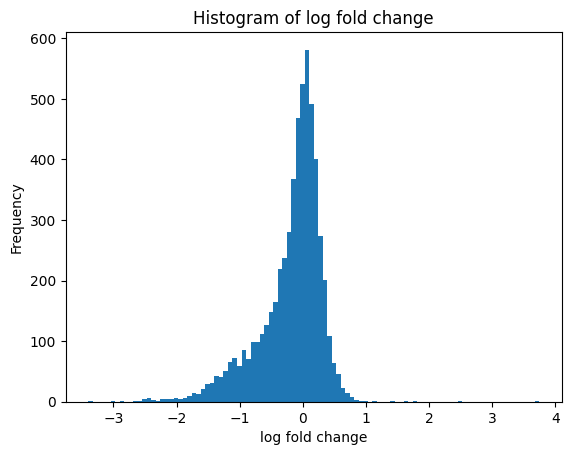

In [3]:
print("Min LFC:", np.min(df_raw['log_fold_change']), " - Max LFC:", np.max(df_raw['log_fold_change']))
plt.hist(df_raw['log_fold_change'], bins=100)
plt.title('Histogram of log fold change')
plt.xlabel('log fold change')
plt.ylabel('Frequency')
plt.show()

### Format Data

In [4]:
df_spacer_split = df_raw['spacer_seq'].apply(lambda x: pd.Series(list(x)))
df_spacer_split.columns = [f'SP{str(i+1).zfill(2)}' for i in range(df_spacer_split.shape[1])]
df = pd.concat([df_spacer_split, df_raw.drop(['spacer_seq'], axis=1)], axis=1)
# df['log_fold_change'] = df['log_fold_change'].apply(lambda x: (((2*(x+0.25))//1) / 2))  # Data bucketing: -0.25->0.25: 0, 0.25->0.75: 0.5, etc.
df = df[df['log_fold_change'] >= -3]
df = df[df['log_fold_change'] < 1]
df['log_fold_change'] = df['log_fold_change'].apply(lambda x: x//1 + 0.5)  # Data bucketing: -2.5, -1.5, -0.5, 0.5
# thresh = 0
# df['log_fold_change'] = df['log_fold_change'].apply(lambda x: int(x > thresh))  # Threshold
print(df.head())

  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    C    T    G    C    A    G    G    A    C    A  ...    G    A    G    C   
1    G    C    T    G    C    A    G    G    A    C  ...    C    G    A    G   
2    T    G    C    T    G    C    A    G    G    A  ...    C    C    G    A   
3    A    G    T    G    C    T    G    C    A    G  ...    G    C    C    C   
4    C    A    G    T    G    C    T    G    C    A  ...    G    G    C    C   

  SP29 SP30 SP31 SP32 SP33 log_fold_change  
0    N    N    N    N    N            -0.5  
1    C    N    N    N    N             0.5  
2    G    C    N    N    N             0.5  
3    G    A    G    C    N             0.5  
4    C    G    A    G    C             0.5  

[5 rows x 34 columns]


Min LFC: -2.5  - Max LFC: 0.5
[-3. -2. -1.  0.  1.]


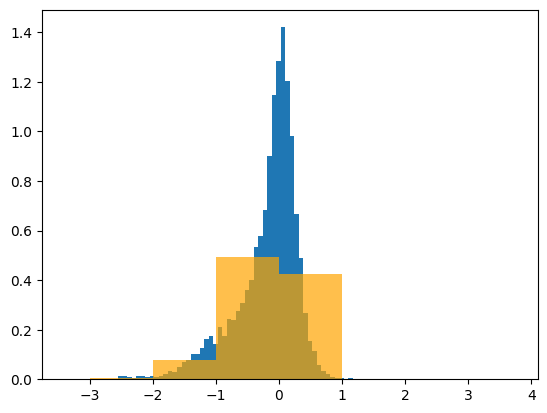

In [5]:
print("Min LFC:", np.min(df['log_fold_change']), " - Max LFC:", np.max(df['log_fold_change']))
plt.hist(df_raw['log_fold_change'], bins=100, density=True)
bins = np.arange(np.min(df['log_fold_change']) - 0.5, np.max(df['log_fold_change']) + 0.6, 1)
print(bins)
plt.hist(df['log_fold_change'], bins=bins, color='orange', alpha=0.7, density=True)
# plt.bar(['No', 'Yes'], [len(df[df['log_fold_change'] == 0]), len(df[df['log_fold_change'] == 1])], color=['blue', 'orange'])
# plt.title('Histogram of Gene Expression change')
# plt.xlabel('Increases Gene Expression')
# plt.ylabel('Frequency')
plt.show()

### Shuffle Data

In [6]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
print(shuffled_df.head())

  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    A    T    T    A    T    T    C    A    C    A  ...    G    T    G    C   
1    G    G    C    A    G    A    T    C    A    C  ...    C    A    G    G   
2    C    T    A    A    G    G    G    A    C    T  ...    G    A    T    C   
3    G    G    G    A    A    A    A    C    A    A  ...    T    C    A    C   
4    G    G    G    T    T    A    G    A    A    C  ...    G    G    G    A   

  SP29 SP30 SP31 SP32 SP33 log_fold_change  
0    T    C    T    C    C            -0.5  
1    A    A    T    T    T            -1.5  
2    T    G    C    C    T            -0.5  
3    T    T    C    G    C            -0.5  
4    C    T    C    C    G            -0.5  

[5 rows x 34 columns]


### Split Data - Train/Test - 80/20

In [7]:
train_length = int(shuffled_df.shape[0]*0.8)
train_data =  shuffled_df.iloc[:train_length].reset_index(drop=True)
test_data =  shuffled_df.iloc[train_length:].reset_index(drop=True)

print("Total Data:", shuffled_df.shape[0])

print("Train Data")
print(train_data.head())
print(train_data.shape)
print()

print("Test Data:")
print(test_data.head())
print(test_data.shape)

Total Data: 5716
Train Data
  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    A    T    T    A    T    T    C    A    C    A  ...    G    T    G    C   
1    G    G    C    A    G    A    T    C    A    C  ...    C    A    G    G   
2    C    T    A    A    G    G    G    A    C    T  ...    G    A    T    C   
3    G    G    G    A    A    A    A    C    A    A  ...    T    C    A    C   
4    G    G    G    T    T    A    G    A    A    C  ...    G    G    G    A   

  SP29 SP30 SP31 SP32 SP33 log_fold_change  
0    T    C    T    C    C            -0.5  
1    A    A    T    T    T            -1.5  
2    T    G    C    C    T            -0.5  
3    T    T    C    G    C            -0.5  
4    C    T    C    C    G            -0.5  

[5 rows x 34 columns]
(4572, 34)

Test Data:
  SP01 SP02 SP03 SP04 SP05 SP06 SP07 SP08 SP09 SP10  ... SP25 SP26 SP27 SP28  \
0    G    G    A    A    G    A    C    A    C    T  ...    G    T    T    A   
1    C    T    

### Test mean estimate accuracy

In [8]:
mean_est = np.mean(train_data['log_fold_change'])
mean_est = round(np.mean(train_data['log_fold_change']))
print("Always estimate change of:", mean_est)
mean_errors = test_data['log_fold_change'] - mean_est
print("Errors:")
print(mean_errors)
print("MSE Loss: ", np.sum(np.square(mean_errors))/test_data.shape[0])
# print("Accuracy:", np.sum(mean_errors == 0)/test_data.shape[0])

Always estimate change of: 0
Errors:
0       0.5
1       0.5
2       0.5
3      -0.5
4      -0.5
       ... 
1139   -0.5
1140   -0.5
1141    0.5
1142    0.5
1143   -0.5
Name: log_fold_change, Length: 1144, dtype: float64
MSE Loss:  0.42832167832167833


## Prepare Bayesian Network - Naive Bayes

In [9]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork()
model.add_edges_from([(df.columns[-1], s) for s in df.columns[:-1]])
model.to_graphviz().draw("naive-bayes.png", prog="dot")
# model_daft = model.to_daft()
# model_daft.render()
# model_daft.savefig('naive-bayes-daft.png')

from pgmpy.estimators import MaximumLikelihoodEstimator
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

from pgmpy.readwrite import XMLBIFWriter
writer = XMLBIFWriter(model)
writer.write_xmlbif('naive-bayes.xml')

cpds = model.get_cpds()
for cpd in cpds:
    print(cpd)

# DO NOT UNCOMMENT - LOADING MODELS KILLED MY PC TWICE!!!
# model.save('naive-model.bif', filetype='bif')

/home/musab/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


+-----------------+-----------------------+-----------------------+-----------------------+----------------------+
| log_fold_change | log_fold_change(-2.5) | log_fold_change(-1.5) | log_fold_change(-0.5) | log_fold_change(0.5) |
+-----------------+-----------------------+-----------------------+-----------------------+----------------------+
| SP01(A)         | 0.4375                | 0.2857142857142857    | 0.298932384341637     | 0.31307929969104015  |
+-----------------+-----------------------+-----------------------+-----------------------+----------------------+
| SP01(C)         | 0.25                  | 0.2257142857142857    | 0.21619217081850534   | 0.20957775489186406  |
+-----------------+-----------------------+-----------------------+-----------------------+----------------------+
| SP01(G)         | 0.09375               | 0.24                  | 0.21085409252669038   | 0.18537590113285274  |
+-----------------+-----------------------+-----------------------+-------------

### Train BN on Data

In [10]:
test_pred = model.predict(test_data.iloc[:, :-1])
print(test_pred)

100%|██████████| 1144/1144 [00:09<00:00, 122.32it/s]


      log_fold_change
0                 0.5
1                -0.5
2                -0.5
3                -0.5
4                -0.5
...               ...
1139             -0.5
1140             -0.5
1141              0.5
1142              0.5
1143             -0.5

[1144 rows x 1 columns]


### Run BN on Data

Errors:
0       0.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
1139    0.0
1140    0.0
1141    0.0
1142    0.0
1143    0.0
Name: log_fold_change, Length: 1144, dtype: float64
MSE Loss:  0.43094405594405594


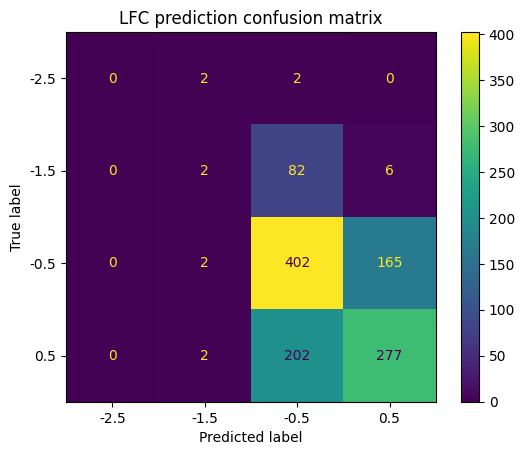

[[  0   2   2   0]
 [  0   2  82   6]
 [  0   2 402 165]
 [  0   2 202 277]]


In [11]:
errors = test_data['log_fold_change'] - test_pred['log_fold_change']
print("Errors:")
print(errors)
print("MSE Loss: ", np.sum(np.square(errors))/test_data.shape[0])
# print("Accuracy:", np.sum(errors == 0)/test_data.shape[0])

confusion_matrix = metrics.confusion_matrix(test_data['log_fold_change']+0.5, test_pred['log_fold_change']+0.5)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [-2.5, -1.5, -0.5, 0.5])

cm_display.plot()
plt.title("LFC prediction confusion matrix")
plt.show()
print(confusion_matrix)
# specificityY= confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
# precisionY= confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
# specificityN= confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[1,0])
# precisionN= confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
# print(f"Yes - specificity: {specificityY}, precision: {precisionY}")
# print(f"No - specificity: {specificityN}, precision: {precisionN}")

## Learning BN

In [12]:
from pgmpy.estimators import HillClimbSearch
est = HillClimbSearch(train_data, use_cache=True)
dag = est.estimate(scoring_method='bdeuscore',
                   start_dag=model
                   )
print(len(dag.nodes()))
print(len(dag.edges()))

model_sl = BayesianNetwork(dag)
model_sl.to_graphviz().draw("struct-learn.png", prog="dot")

from pgmpy.estimators import MaximumLikelihoodEstimator
model_sl.fit(train_data, estimator=MaximumLikelihoodEstimator)

from pgmpy.readwrite import XMLBIFWriter
writer = XMLBIFWriter(model_sl)
writer.write_xmlbif('struct-learn.xml')

cpds = model_sl.get_cpds()
for cpd in cpds:
    print(cpd)

  0%|          | 53/1000000 [00:05<27:51:30,  9.97it/s]


34
30
+---------+---------------------+---------------------+---------------------+---------+---------------------+
| SP02    | SP02(A)             | SP02(C)             | SP02(G)             | SP02(N) | SP02(T)             |
+---------+---------------------+---------------------+---------------------+---------+---------------------+
| SP01(A) | 0.3400431344356578  | 0.2961418143899896  | 0.3458980044345898  | 0.0     | 0.24677296886864086 |
+---------+---------------------+---------------------+---------------------+---------+---------------------+
| SP01(C) | 0.25305535585909417 | 0.2210636079249218  | 0.10643015521064302 | 0.0     | 0.24297646165527714 |
+---------+---------------------+---------------------+---------------------+---------+---------------------+
| SP01(G) | 0.18619698058950396 | 0.2064650677789364  | 0.25055432372505543 | 0.0     | 0.18071374335611237 |
+---------+---------------------+---------------------+---------------------+---------+---------------------+
| SP

In [13]:
test_pred = model_sl.predict(test_data.iloc[:, :-1])
print(test_pred)

100%|██████████| 1144/1144 [00:00<00:00, 1199.41it/s]


      log_fold_change
0                 0.5
1                -0.5
2                -0.5
3                -0.5
4                -0.5
...               ...
1139             -0.5
1140             -0.5
1141              0.5
1142              0.5
1143             -0.5

[1144 rows x 1 columns]


Errors:
0       0.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
1139    0.0
1140    0.0
1141    0.0
1142    0.0
1143    0.0
Name: log_fold_change, Length: 1144, dtype: float64
MSE Loss:  0.5253496503496503


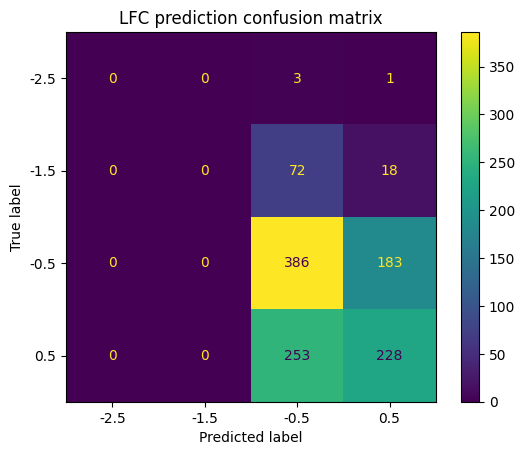

[[  0   0   3   1]
 [  0   0  72  18]
 [  0   0 386 183]
 [  0   0 253 228]]


In [14]:
errors = test_data['log_fold_change'] - test_pred['log_fold_change']
print("Errors:")
print(errors)
print("MSE Loss: ", np.sum(np.square(errors))/test_data.shape[0])
# print("Accuracy:", np.sum(errors == 0)/test_data.shape[0])
confusion_matrix = metrics.confusion_matrix(test_data['log_fold_change']+0.5, test_pred['log_fold_change']+0.5)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [-2.5, -1.5, -0.5, 0.5])

cm_display.plot()
plt.title("LFC prediction confusion matrix")
plt.show()
print(confusion_matrix)
# specificityY= confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
# precisionY= confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
# specificityN= confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[1,0])
# precisionN= confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
# print(f"Yes - specificity: {specificityY}, precision: {precisionY}")
# print(f"No - specificity: {specificityN}, precision: {precisionN}")